# Inference Qwen2.5-VL-3B

### Load Model

In [1]:
import os
os.environ["HF_HOME"] = "/tmp/huggingface_cache"

In [2]:
!echo $HF_HOME

/tmp/huggingface_cache


### Baseline

In [3]:
from wrapper.local_llm import LocalLLM

model = LocalLLM(
    model_id="Qwen/Qwen2.5-VL-3B-Instruct",  # The original base model
)
model.load()

/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️ Loading Qwen/Qwen2.5-VL-3B-Instruct (4-bit: False)...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


✅ Model Ready.


### Finetunned (3 epochs)

In [3]:
from wrapper.local_llm import LocalLLM

model = LocalLLM(
    model_id="Qwen/Qwen2.5-VL-3B-Instruct",  # The original base model
    adapter_id="./output/signature_model/best_model", # Your trained LoRA adapters
)
model.load()

/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️ Loading Qwen/Qwen2.5-VL-3B-Instruct (4-bit: False)...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


🔗 Merging Adapter: ./output/signature_model/best_model
✅ Model Ready.


## Methods for manipulation

### Tool for inference zero_shot

#### Baseline

In [9]:
def zero_shot_inference(model, processor, image, prompt):
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": image,
              },
              {"type": "text", "text": prompt},
          ],
      }
  ]
  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")
  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, do_sample=True, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )[0]
  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14
  return output_text, input_height, input_width

### For visualization purposes

In [10]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
def plot_bounding_boxes(image, bbox_data, height, width,Ground_T):
  image = image.resize((width, height))
  # Parse the JSON input
  # Plot the image
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  ax.axis('off')
  # Plot the bounding boxes and labels
  for item in bbox_data:
      bbox = item['bbox_2d']
      label = item['label']
      rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none',label='Prediction')
      ax.add_patch(rect)
      plt.text(bbox[0], bbox[1] - 10, label, color='r', fontsize=10)
  for item in Ground_T:
    rect = patches.Rectangle((item[0], item[1]), item[2] - item[0], item[3] - item[1], linewidth=2, edgecolor='g', facecolor='none',label='Ground Truth')
    ax.add_patch(rect)
  plt.legend(loc='upper right')
  plt.show()

### Metrics used to evalute performance
- Hard evaluation metrics: 
    - IoU: The standard academic benchmark.
- Soft evaluation metrics:
    - Iop: Intersection over prediction, how much of your predicted box is inside the ground Truth
    - Center-point hit: if the center of the predicted box is inside the center 
    - Center distance error: The distance between the center of the predicted box and the center of the ground truth

In [4]:
import math

def evaluate_detection(pred_box, gt_box, img_width=1, img_height=1):
    """
    Evaluates prediction against ground truth with distance metrics.
    
    Args:
        pred_box (list): [xmin, ymin, xmax, ymax]
        gt_box (list):   [xmin, ymin, xmax, ymax]
        img_width (int): Width of the image (for normalization)
        img_height (int): Height of the image (for normalization)
        
    Returns:
        dict: IoU, IoP, Center Distance (Pixels), Normalized Center Distance (0-1)
    """
    # --- 1. IoU Calculation (Standard) ---
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    predArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gtArea = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    
    iou = interArea / float(predArea + gtArea - interArea + 1e-6)
    iop = interArea / float(predArea + 1e-6) # Intersection over Prediction

    # --- 2. Center Point Calculation ---
    pred_cx = (pred_box[0] + pred_box[2]) / 2.0
    pred_cy = (pred_box[1] + pred_box[3]) / 2.0
    
    gt_cx = (gt_box[0] + gt_box[2]) / 2.0
    gt_cy = (gt_box[1] + gt_box[3]) / 2.0
    
    # --- 3. Euclidean Distance (Pixels) ---
    # Pythagorean theorem: a^2 + b^2 = c^2
    dist_pixels = math.sqrt((pred_cx - gt_cx)**2 + (pred_cy - gt_cy)**2)
    
    # --- 4. Normalized Distance (0.0 to 1.0) ---
    # Distance relative to the image diagonal. 
    # 0.05 means the center is off by 5% of the image size.
    # This helps compare errors across images of different resolutions.
    img_diagonal = math.sqrt(img_width**2 + img_height**2) + 1e-6
    norm_dist = dist_pixels / img_diagonal

    return {
        "iou": round(iou, 4),
        "iop": round(iop, 4),
        "center_dist_px": round(dist_pixels, 1),
        "norm_center_dist": round(norm_dist, 4)
    }

### Load test images and ground_truth

In [7]:
import json

test_json_path = 'data/test.jsonl'
test_json = []

with open(test_json_path, 'r', encoding='utf-8') as f:
    for line in f:
        data=json.loads(line)
        image_path = 'data/'+data['image']
        groundTruth = json.loads(data['label'])
        test_json.append({
                        'image_path': image_path,
                        'groundTruth': groundTruth
                        })

# Now test_json is a list of dictionaries
print(test_json)

[{'image_path': 'data/images/test_sma35f00_jpg.rf.375b78dcdffebf3c1df37be8bc542a54_orig.jpg', 'groundTruth': [{'bbox_2d': [556, 679, 762, 753], 'label': 'signature'}]}, {'image_path': 'data/images/test_fpi68d00_jpg.rf.018370284c3e2792907dce239cc5db3e_orig.jpg', 'groundTruth': [{'bbox_2d': [464, 539, 767, 585], 'label': 'signature'}]}, {'image_path': 'data/images/test_kgr04f00-page3_3_jpg.rf.4bd5ceb1eb2f6e32dda1972a05d51ab8_orig.jpg', 'groundTruth': [{'bbox_2d': [548, 656, 685, 692], 'label': 'signature'}]}, {'image_path': 'data/images/test_bea69d00_jpg.rf.a7f280479812110e66c2db0499f00677_orig.jpg', 'groundTruth': [{'bbox_2d': [643, 429, 740, 464], 'label': 'signature'}]}, {'image_path': 'data/images/test_wau30a00-page9_16_jpg.rf.b34c9bbb606cc9975a0dcc54c0fa9dab_orig.jpg', 'groundTruth': [{'bbox_2d': [204, 262, 434, 309], 'label': 'signature'}]}, {'image_path': 'data/images/test_fmr56e00_jpg.rf.77ceaac885aeb1af4be46cc2ac61ba6c_orig.jpg', 'groundTruth': [{'bbox_2d': [303, 354, 417, 398],

In [6]:
def parse_ground_truth(Ground_T):
    """
    Extracts GT boxes from Qwen format: <box>(y1,x1),(y2,x2)</box>
    Returns list of [x1, y1, x2, y2] on 0-1000 scale.
    """
    bboxes = []
    for item in Ground_T:
        label = item['label']
        bbox = item['bbox_2d']
        bboxes.append(bbox)
    return bboxes

In [7]:
import numpy as np

def calculate_iou(boxA, boxB):
    # Standard IoU calculation
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Matches predictions to ground truths using greedy IoU strategy.
    
    Args:
        pred_boxes (list): List of [xmin, ymin, xmax, ymax]
        gt_boxes (list):   List of [xmin, ymin, xmax, ymax]
        iou_threshold (float): Minimum IoU to consider a match valid
        
    Returns:
        matches (list): List of dicts {'pred': box, 'gt': box, 'iou': float}
        unmatched_preds (list): List of pred_boxes that matched nothing
        unmatched_gts (list): List of gt_boxes that were missed
    """
    matches = []
    # pred_boxes = [box['bbox_2d'] for box in pred_boxes]
    
    # Keep track of which indices have been matched
    matched_pred_indices = set()
    matched_gt_indices = set()
    
    # 1. Calculate IoU for ALL pairs
    # Format: (iou, pred_index, gt_index)
    all_pairs = []
    for i, p_box in enumerate(pred_boxes):
        for j, g_box in enumerate(gt_boxes):
            iou = calculate_iou(p_box, g_box)
            if iou > 0.0: # Only consider pairs that overlap at least a little
                all_pairs.append((iou, i, j))
    
    # 2. Sort pairs by IoU (Highest first)
    all_pairs.sort(key=lambda x: x[0], reverse=True)
    
    # 3. Greedy Matching
    for iou, p_idx, g_idx in all_pairs:
        if p_idx not in matched_pred_indices and g_idx not in matched_gt_indices:
            # Found the best remaining match!
            if iou >= iou_threshold:
                matches.append({
                    'pred': pred_boxes[p_idx],
                    'gt': gt_boxes[g_idx],
                    'iou': iou
                })
                matched_pred_indices.add(p_idx)
                matched_gt_indices.add(g_idx)
    
    # 4. Gather leftovers
    unmatched_preds = [p for i, p in enumerate(pred_boxes) if i not in matched_pred_indices]
    unmatched_gts = [g for i, g in enumerate(gt_boxes) if i not in matched_gt_indices]
    
    return matches, unmatched_preds, unmatched_gts

### Running the inference test on single image

### Baseline

Predicted Bounding Boxes: [{'label': 'signature', 'bbox_2d': [370, 804, 569, 862]}]
False Positives (Hallucinations): 0
Missed Signatures: 1


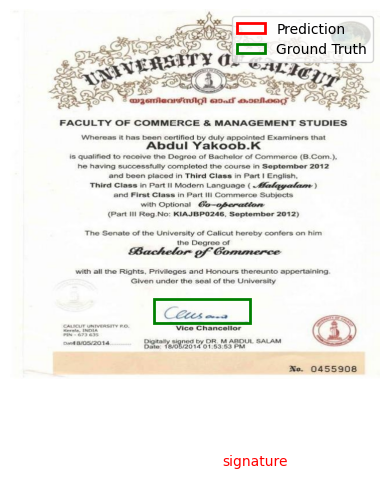

In [10]:
from PIL import Image
prompt = "Detect all signatures and return their locations and labels in the form of coordinates. ```json\n[{\"label\": \"signature\", \"bbox_2d\": [x1, y1, x2, y2]}, ...]\n```"
for item in test_json:
    image_path = item['image_path']
    Ground_T = parse_ground_truth(item['groundTruth'])
    image = Image.open(image_path).convert('RGB')
    output_text, height, width = zero_shot_inference(model, processor, image, prompt)
    #print(f"Output Text: {output_text}")
    #parsing of output
    #json_predict = output_text.split('```json')[1].split('```')[0]
    bbox_data_predict = json.loads(output_text)
    pred_boxes = [x['box_2d'] for x in bbox_data_predict if 'box_2d' in x]

    print(f"Predicted Bounding Boxes: {bbox_data_predict}")
    matches, false_positives, misses = match_predictions_to_ground_truth(pred_boxes, Ground_T, iou_threshold=0.1)
    for match in matches:
        # Use your detailed metric function here
        metrics = evaluate_detection(match['pred'], match['gt'], img_width=width, img_height=height)
        
        # Store these specific metrics
        # e.g., results.append(metrics)
        print(f"Matched with IoU: {metrics['iou']}, IoP: {metrics['iop']}, Center Dist: {metrics['center_dist_px']}px, Normalized Dist: {metrics['norm_center_dist']}")

    print(f"False Positives (Hallucinations): {len(false_positives)}")
    print(f"Missed Signatures: {len(misses)}")   
    
    plot_bounding_boxes(image, bbox_data_predict, height, width, Ground_T)
    
    break #single image

### Fine tunned

In [10]:
final_answer= output_text.split('```json')[1].split('```')[0]
final_answer_json = json.loads(final_answer)
print(final_answer_json)

[{'label': 'signatures', 'box_2d': [268, 517, 413, 549]}]


In [ ]:
import torch
import json
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from peft import PeftModel
from qwen_vl_utils import process_vision_info

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the base model
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
# Path to YOUR fine-tuned adapters (Update this!)
adapter_path = "qwen2.5-vl-signature-detector" 
# Your Test Data (List of dicts with 'image_path' and 'groundTruth')
# Assuming test_json is already loaded in your environment. 
# If not, load it here: test_json = [...] 

# ==========================================
# 2. LOAD MODEL (Base + LoRA)
# ==========================================
print("⏳ Loading Base Model...")
base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.bfloat16, 
    device_map="auto"
)

print(f"⏳ Loading Adapters from {adapter_path}...")
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval() # Set to evaluation mode

processor = AutoProcessor.from_pretrained(model_id)


/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


⏳ Loading Base Model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


⏳ Loading Adapters from ./output/best_model...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [5]:

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def extract_box_from_text(text):
    """
    Robustly extracts [xmin, ymin, xmax, ymax] using Regex.
    Fixes the issue where the model repeats numbers infinitely.
    """
    # Look for a pattern like: "box_2d": [123, 456, 789, 101
    # We only capture the first 4 numbers.
    pattern = r"box_2d\":\s*\[\s*(\d+),\s*(\d+),\s*(\d+),\s*(\d+)"
    match = re.search(pattern, text)
    
    if match:
        return [int(match.group(1)), int(match.group(2)), int(match.group(3)), int(match.group(4))]
    return None

def denormalize_box(box, img_w, img_h):
    """Converts 0-1000 coordinates to pixels"""
    if not box: return None
    return [
        (box[0] / 1000) * img_w,
        (box[1] / 1000) * img_h,
        (box[2] / 1000) * img_w,
        (box[3] / 1000) * img_h,
    ]

def plot_result(img_path, pred_box, gt_box=None):
    """Visualizes the result"""
    img = Image.open(img_path)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # Draw Prediction (Red)
    if pred_box:
        x1, y1, x2, y2 = pred_box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=3, edgecolor='r', facecolor='none', label='Prediction')
        ax.add_patch(rect)
        ax.text(x1, y1-5, 'Signature', color='white', fontsize=12, backgroundcolor='red')

    # Draw Ground Truth (Green) - Optional
    if gt_box:
        # Assuming gt_box is already pixels [x1, y1, x2, y2]
        gx1, gy1, gx2, gy2 = gt_box
        gw, gh = gx2 - gx1, gy2 - gy1
        rect_gt = patches.Rectangle((gx1, gy1), gw, gh, linewidth=2, edgecolor='g', facecolor='none', linestyle='--', label='Ground Truth')
        ax.add_patch(rect_gt)

    plt.legend()
    plt.axis('off')
    plt.show()


In [6]:
train_json=[{"image": "data/images/train_qcw00f00-page02_2_jpg.rf.932e2b741fef4150c5055eb7a27ecf07_orig.jpg", "label": "[{\"bbox_2d\": [264, 120, 358, 139], \"label\": \"signatures\"}, {\"bbox_2d\": [180, 191, 268, 205], \"label\": \"signatures\"}]"}
]


🚀 Starting Inference on 1 images...

[1/1] Processing: data/images/train_qcw00f00-page02_2_jpg.rf.932e2b741fef4150c5055eb7a27ecf07_orig.jpg
   🤖 Raw Output: [{"bbox_2d": [345, 376, 489, 410], "label": "signatures"}]
   🎯 Normalized Box: [345, 376, 489, 410]
   ✅ Detected Box: [353.28, 385.024, 500.736, 419.84]


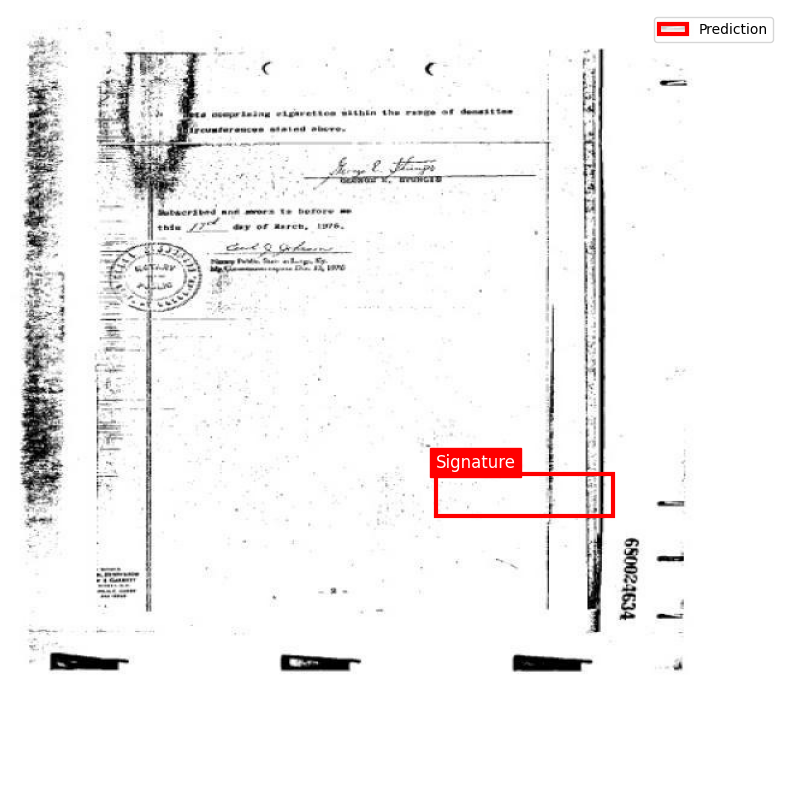

In [11]:

# ==========================================
# 4. INFERENCE LOOP
# ==========================================
# The prompt must match the data format (Box First!)
user_prompt = (
    "You are an object detector. Detect the signature. "
    "Return a strictly valid JSON list. "
    "Format: [{'box_2d': [xmin, ymin, xmax, ymax], 'label': 'signature'}]. "
    "Coordinates must be normalized 0-1000."
)

print(f"\n🚀 Starting Inference on {len(train_json)} images...\n")

for i, item in enumerate(train_json):
    image_path = item['image']
    print(f"[{i+1}/{len(train_json)}] Processing: {image_path}")
    
    # -----------------------------------------------
    # A. PREPARE INPUTS (The Correct Way)
    # -----------------------------------------------
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": user_prompt},
            ],
        }
    ]
    
    # Prepare text for the model
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Extract and resize image using Qwen Utils
    image_inputs, video_inputs = process_vision_info(messages)
    
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to(model.device)

    # -----------------------------------------------
    # B. GENERATE (With Loop Prevention)
    # -----------------------------------------------
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=128,      # Stop it from rambling
            do_sample=False,         # Deterministic (best for coords)
            repetition_penalty=1.1,  # 🛑 Penalize repeating numbers
            temperature=0.1          # Low temp for precision
        )

    # Decode only the new tokens
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    print(f"   🤖 Raw Output: {output_text}")

    # -----------------------------------------------
    # C. PARSE & PLOT
    # -----------------------------------------------
    # 1. Get Image Size
    with Image.open(image_path) as img:
        width, height = img.size

    # 2. Extract [x, y, x, y] using Regex
    norm_box = extract_box_from_text(output_text)
    print(f"   🎯 Normalized Box: {norm_box}")

    if norm_box:
        # 3. Convert to Pixels
        pixel_box = denormalize_box(norm_box, 1024, 1024)
        print(f"   ✅ Detected Box: {pixel_box}")
        
        # 4. Visualize
        # Pass your ground truth parser here if you have it: parse_ground_truth(item['groundTruth'])
        plot_result(image_path, pixel_box, gt_box=None) 
    else:
        print("   ❌ No valid box found in output.")

    # Remove this break to run on all images
    break

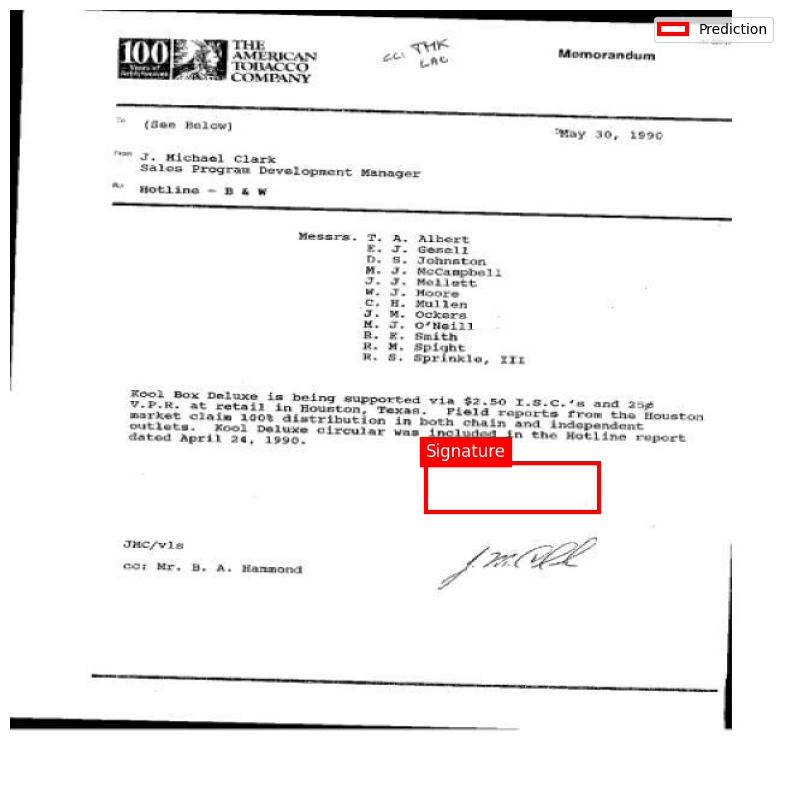

In [9]:
plot_result(image_path, norm_box, gt_box=None) 


   🎯 Final Decoded Box: [551.9999999999999, -15.999999999999886, 782.4, 38.39999999999998]
   🎯 Final Decoded Box (Re-Denormalized): [144.703488, 237.63353600000002, 205.10146559999998, 251.89416960000003]


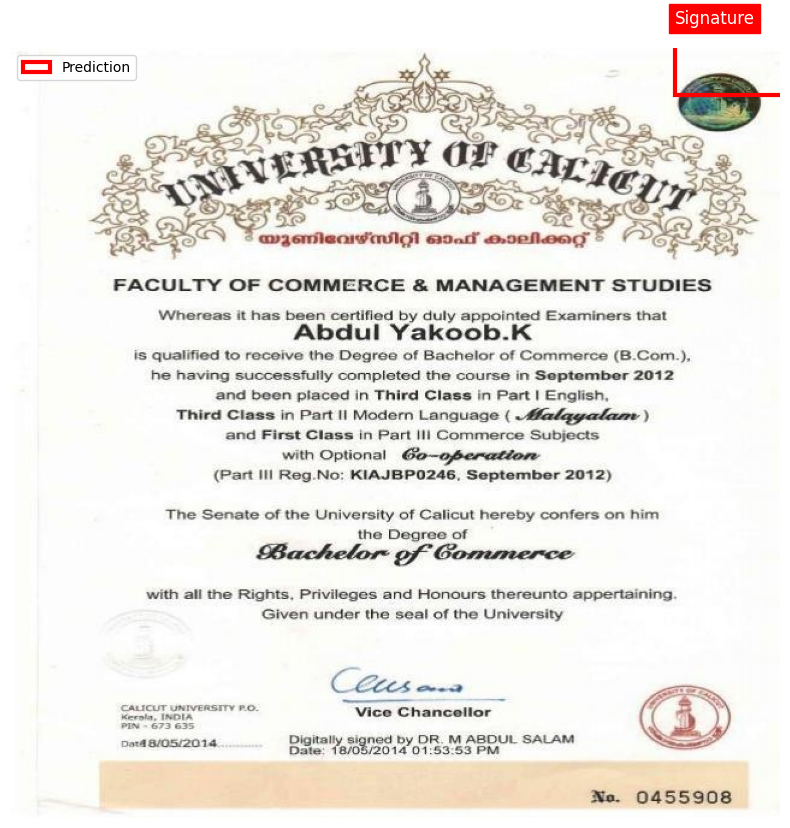

In [44]:
def universal_box_decoder(box, img_w, img_h):
    """
    Decodes [n1, n2, n3, n4] robustly, handling PDF flips and unsorted coords.
    """
    if not box or len(box) < 4: return None
    
    n1, n2, n3, n4 = box
    
    # 1. ASSUME: [x1, y1, x2, y2] format
    # But we don't know if y1 is Top or Bottom.
    
    # Scale to pixels first
    x_a = (n1 / img_w) * 1000
    y_a = (n2 / img_h) * 1000
    x_b = (n3 / img_w) * 1000
    y_b = (n4 / img_h) * 1000
    
    # 2. FORCE VALIDITY (The Min/Max Trick)
    # This fixes "Negative Height" instantly.
    # It doesn't matter if 467 is Top or Bottom; min() always finds the top pixel.
    
    xmin = min(x_a, x_b)
    xmax = max(x_a, x_b)
    ymin = min(y_a, y_b)
    ymax = max(y_a, y_b)
    
    # 3. PDF INVERSION CHECK (The "Way Far" Fix)
    # If your boxes are appearing mirrored at the bottom/top of the page,
    # it means we need to flip the Y-axis entirely.
    
    # UNCOMMENT THIS IF THE BOXES ARE STILL WRONG:
    return [xmin, img_h - ymax, xmax, img_h - ymin]
    
    return [xmin, ymin, xmax, ymax]
test_box=universal_box_decoder(pixel_box, img_w=width, img_h=height)
print(f"   🎯 Final Decoded Box: {test_box}")
print(f"   🎯 Final Decoded Box (Re-Denormalized): {test_box_2}")
plot_result(image_path, test_box, gt_box=None)

### Running the inference test images

### Baseline

In [15]:
import numpy as np
import json
from PIL import Image
from tqdm import tqdm

# --- 1. Initialize Accumulators ---
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

user_prompt ="Detect the bounding boxes of the signatures."

print(f">> Starting evaluation on {len(test_json)} images...")

# --- 2. Main Loop ---
for item in tqdm(test_json):
    image_path = item['image_path']
    
    # Load GT and Image
    try:
        Ground_T = parse_ground_truth(item['groundTruth']) # Ensure this returns list of [x1, y1, x2, y2]
        image = Image.open(image_path).convert('RGB')
        metrics_summary["total_images"] += 1
    except Exception as e:
        print(f"Skipping {image_path}: {e}")
        continue

    # Inference
    try:
        output_text, height, width = model.predict(image_path, prompt=user_prompt)
        try:
            output_text=output_text.split('```json')[1].split('```')[0]
            final_answer=model.postprocess(raw_results=json.loads(output_text), img_h=height, img_w=width, normalize=False)
        except Exception as e:
            print("Error parsing output: ", e)
            final_answer=model.postprocess(raw_results=json.loads(output_text), img_h=height, img_w=width, normalize=False)
        
        # Extract just the boxes for matching [x1, y1, x2, y2]
        # Assuming bbox_data_predict is list of dicts: [{'bbox_2d': [...], ...}]
        pred_boxes = [x['box_2d'] for x in final_answer if 'box_2d' in x]

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        print(f"Raw Model Output: {output_text}")
        pred_boxes = []
    # Match Predictions to Ground Truth
    matches, false_positives, misses = match_predictions_to_ground_truth(pred_boxes, Ground_T, iou_threshold=0.1)
    
    # Update Totals for FP / FN
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=width, img_height=height)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])
# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

>> Starting evaluation on 257 images...


  6%|▌         | 15/257 [00:16<04:21,  1.08s/it]

Error parsing output:  Expecting value: line 3 column 12 (char 14)
Error processing data/images/test_qit05f00-page2_26_jpg.rf.66c0f072dd82379ebbab695fbac61b80_orig.jpg: Expecting value: line 3 column 12 (char 14)
Raw Model Output: 
[
	{"label": 'signatures', "box_2d": [498, 136, 537, 294] }
]



 63%|██████▎   | 161/257 [02:55<01:54,  1.20s/it]

Error parsing output:  Expecting value: line 3 column 12 (char 14)
Error processing data/images/test_sik79d00_jpg.rf.998bb80ae83e0bab9d7d8710ba233bd7_orig.jpg: Expecting value: line 3 column 12 (char 14)
Raw Model Output: 
[
	{"label": 'signatures', "box_2d": [364, 597, 438, 644] }
]



100%|██████████| 257/257 [04:40<00:00,  1.09s/it]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      163
Total Missed Signatures:  157
Total False Positives:    69
--------------------------------------------------
Mean IoU (Overlap):             0.5584
Mean IoP (Tightness/Precision): 0.7777
Mean Normalized Center Error:   0.0212 (2.12% of image diagonal)


### Fine tunned

In [14]:
import numpy as np
import json
from PIL import Image
from tqdm import tqdm

# --- 1. Initialize Accumulators ---
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

user_prompt ="Detect the bounding boxes of the signatures."

print(f">> Starting evaluation on {len(test_json)} images...")

# --- 2. Main Loop ---
for item in tqdm(test_json):
    image_path = item['image_path']
    
    # Load GT and Image
    try:
        Ground_T = parse_ground_truth(item['groundTruth']) # Ensure this returns list of [x1, y1, x2, y2]
        image = Image.open(image_path).convert('RGB')
        metrics_summary["total_images"] += 1
    except Exception as e:
        print(f"Skipping {image_path}: {e}")
        continue

    # Inference
    try:
        output_text, height, width = model.predict(image_path, prompt=user_prompt)
        # print("output_answer: ", output_text)
        # print("output_json",json.loads(output_text))
        try:
            final_answer=model.postprocess(raw_results=json.loads(output_text), img_h=height, img_w=width, normalize=False)
        except Exception as e:
            print("Error parsing output: ", e)
          
            output_text=output_text.split('```json')[1].split('```')[0]
            final_answer=model.postprocess(raw_results=json.loads(output_text), img_h=height, img_w=width, normalize=False)
        
        # Extract just the boxes for matching [x1, y1, x2, y2]
        # Assuming bbox_data_predict is list of dicts: [{'bbox_2d': [...], ...}]
        pred_boxes = [x['box_2d'] for x in final_answer if 'box_2d' in x]

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        print(f"Raw Model Output: {output_text}")
        pred_boxes = []
    # Match Predictions to Ground Truth
    matches, false_positives, misses = match_predictions_to_ground_truth(pred_boxes, Ground_T, iou_threshold=0.1)
    
    # Update Totals for FP / FN
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=width, img_height=height)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])
# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

>> Starting evaluation on 257 images...


 16%|█▌        | 40/257 [00:45<04:05,  1.13s/it]

Error parsing output:  Expecting ',' delimiter: line 4 column 2 (char 26)
Error processing data/images/test_jrk44a00_jpg.rf.e52fbd4e6f48e5eee1ffccb9f2df038f_orig.jpg: list index out of range
Raw Model Output: [[
[498,76,563,352], [
]
]


 49%|████▊     | 125/257 [02:28<02:43,  1.24s/it]

Error parsing output:  Expecting ',' delimiter: line 3 column 2 (char 60)
Error processing data/images/test_bfk68c00-page03_3_jpg.rf.050a0516df8f6e744753c2ed22270e92_orig.jpg: list index out of range
Raw Model Output: [[
{"bbox_2d": [223, 386, 264, 567], "label": "signature"}
]


 63%|██████▎   | 161/257 [03:10<01:47,  1.12s/it]

Error parsing output:  Expecting ',' delimiter: line 2 column 14 (char 16)
Error processing data/images/test_sik79d00_jpg.rf.998bb80ae83e0bab9d7d8710ba233bd7_orig.jpg: list index out of range
Raw Model Output: [[
  "Signature": [
    {
      "bbox_2d": [37, 285, 124, 586],
      "label": "Signature"
    }
  ]
]}


 74%|███████▍  | 191/257 [03:44<01:10,  1.07s/it]

Error parsing output:  Expecting value: line 2 column 20 (char 22)
Error processing data/images/test_image_7_jpg.rf.530ddd39e38edc758db0d0d2257637bf_orig.jpg: list index out of range
Raw Model Output: [[
[403,358,456,507], ]
]


100%|██████████| 257/257 [05:01<00:00,  1.17s/it]


 FINAL EVALUATION REPORT (257 Images)
Total Matches Found:      96
Total Missed Signatures:  224
Total False Positives:    18
--------------------------------------------------
Mean IoU (Overlap):             0.6515
Mean IoP (Tightness/Precision): 0.7629
Mean Normalized Center Error:   0.0160 (1.60% of image diagonal)
